In [1]:
import pandas as pd
from src.plot import *
import numpy as np
from src.stat import chi_2
import datetime
from dateutil.relativedelta import relativedelta
pd.options.display.float_format = "{:,.2f}".format

In [2]:
df = pd.read_csv('loan.csv')

In [3]:
#Select apropriate columns

numerical = df.select_dtypes('number').columns
dates = ['issue_d','earliest_cr_line','last_pymnt_d']
categorical = df.select_dtypes('object').columns
categorical = [c for c in categorical if c not in dates]
default_columns = ['Charged Off', 'Default', 'Does not meet the credit policy. Status:Charged Off', 'Late (31-120 days)']
df['target'] = df['loan_status'].apply(lambda x: 1 if x in default_columns else 0)
valid = default_columns + ['Fully Paid','Does not meet the credit policy. Status:Fully Paid']
dfv = df[df.loan_status.isin(valid)].copy()


In [4]:
#convert dates

for d in dates:
    dfv[d] = pd.to_datetime(dfv[d],format='%b-%Y')

In [5]:
# convert term into no months

dfv['term'] = dfv['term'].str.extract(r'(\d{2})').astype('int')


In [6]:
# now I will check if letter in grade = letter in subgrade 

df['grade_check'] = df.apply(lambda x: x['grade'] in x['sub_grade'], axis = 1)


#all good DQ checked


In [7]:
df.groupby('grade')['target'].mean()
#as expected the highest default rate is in the most risky 

grade
A   0.03
B   0.08
C   0.14
D   0.20
E   0.28
F   0.36
G   0.40
Name: target, dtype: float64

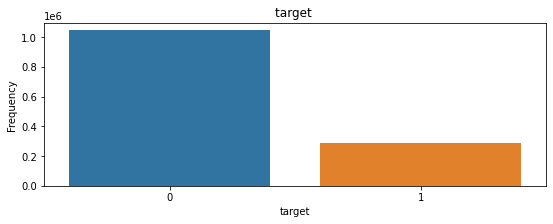

<module 'matplotlib.pyplot' from '/Users/aleksandram/.local/share/virtualenvs/PD-scoring-Yvrhi1rQ/lib/python3.9/site-packages/matplotlib/pyplot.py'>

In [8]:
plot_cnt(dfv, 'target')

#looks like unbalanced dataset

In [9]:
# there is 12% default rate
dfv['target'].mean()

0.21406867808390376

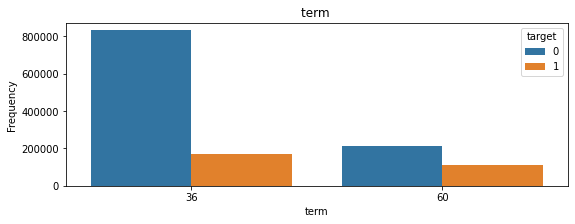

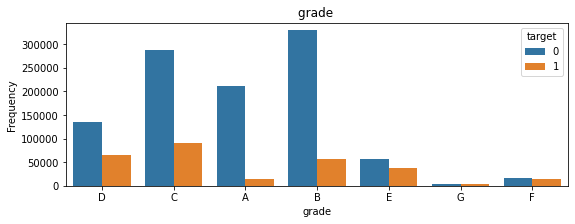

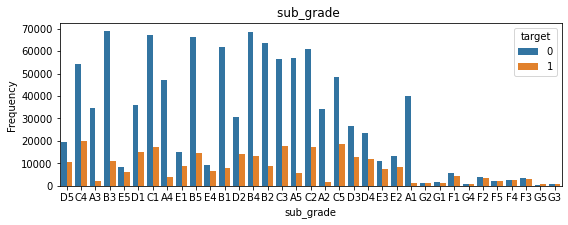

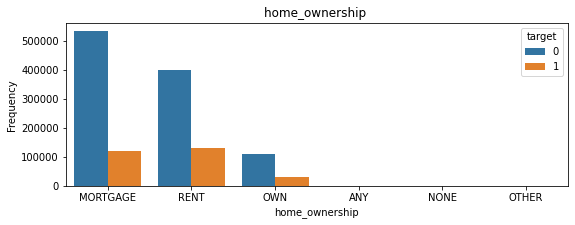

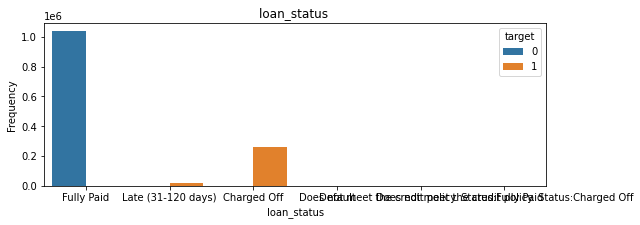

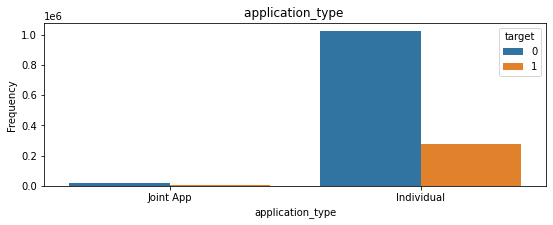

In [10]:
for c in categorical:
    plot_cnt(dfv,c, hue='target')

In [11]:
for c in categorical:
    print(c)
    chi_2(dfv, c)


# All categorical features have impact on target variable

term
chi_2 statistic: 43325.95
p_value: 0.00
significant level 0.05
Reject H0, variables have dependency
grade
chi_2 statistic: 92318.11
p_value: 0.00
significant level 0.05
Reject H0, variables have dependency
sub_grade
chi_2 statistic: 96823.10
p_value: 0.00
significant level 0.05
Reject H0, variables have dependency
home_ownership
chi_2 statistic: 6916.20
p_value: 0.00
significant level 0.05
Reject H0, variables have dependency
loan_status
chi_2 statistic: 1328284.00
p_value: 0.00
significant level 0.05
Reject H0, variables have dependency
application_type
chi_2 statistic: 1458.56
p_value: 0.00
significant level 0.05
Reject H0, variables have dependency


### New features

In [12]:
def diff_month(d1, d2):
    return (d1.year - d2.year) * 12 + d1.month - d2.month

In [13]:
dfv['monthly_inc'] = dfv['annual_inc']/12
dfv['expected_payment_dt'] = dfv.apply(lambda x: x['issue_d'] + relativedelta(months=x['term']), axis =1)
dfv['months_paid'] = dfv.apply(lambda x: diff_month(x['last_pymnt_d'],x['issue_d']), axis=1)

KeyboardInterrupt: 

In [ ]:
frequent_values = dfv['annual_inc'].value_counts()[dfv['annual_inc'].value_counts() > 20000].index

In [ ]:
dfv['pure_installment'] = dfv['installment']/(1+df['int_rate']/100)
dfv['annual_installment'] = dfv['installment']*12
dfv['total_installment_pure'] = dfv['pure_installment']
dfv['relationship_months'] = dfv.apply(lambda x: diff_month(x['issue_d'],x['earliest_cr_line']), axis=1)
dfv['frequent_income'] = dfv['annual_inc'].apply(lambda x: 1 if x in frequent_values else 0 )
dfv['total_loan_amount'] = dfv['installment']*dfv['term']


In [ ]:
#I would be interested in 1st rate that occured

#Filtering out Current, in grace period, curren


#filtering DQ issue where Income is 0 
#dfv = dfv[dfv]


<Figure size 648x216 with 0 Axes>

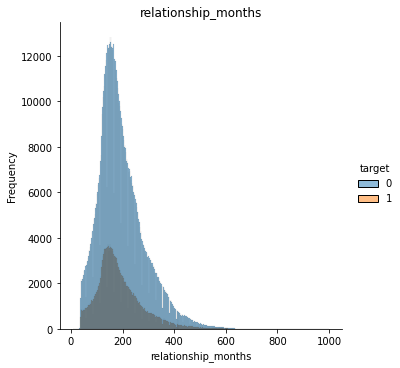

<Figure size 648x216 with 0 Axes>

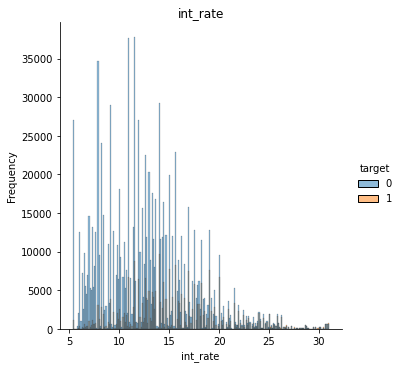

<Figure size 648x216 with 0 Axes>

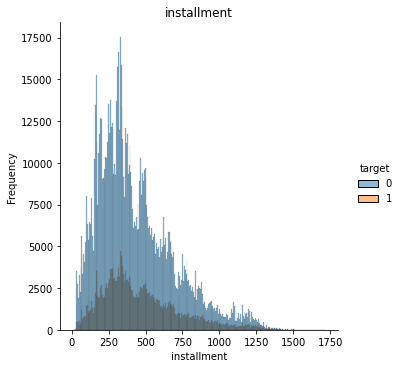

<Figure size 648x216 with 0 Axes>

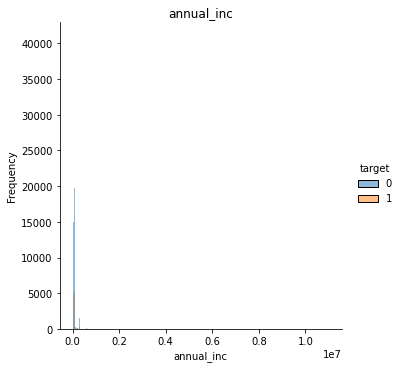

<Figure size 648x216 with 0 Axes>

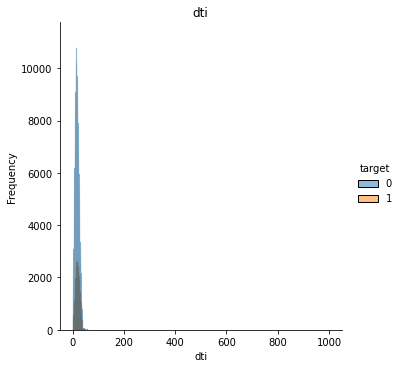

<Figure size 648x216 with 0 Axes>

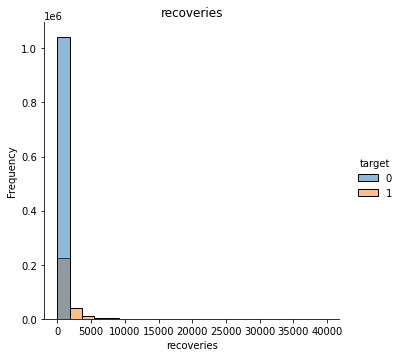

In [ ]:
plot_histogram(dfv, 'relationship_months', hue='target')
for c in numerical:
    plot_histogram(dfv,c, hue='target')

In [ ]:
dfv.head()

,term,int_rate,installment,grade,sub_grade,home_ownership,annual_inc,issue_d,loan_status,dti,...,target,monthly_inc,expected_payment_dt,months_paid,pure_installment,annual_installment,total_installment_pure,relationship_months,frequent_income,total_loan_amount
100,36,22.35,"1,151.16",D,D5,MORTGAGE,"100,000.00",2018-12-01,Fully Paid,30.46,...,0,"8,333.33",2021-12-01,1.00,940.87,"13,813.92",940.87,83.00,1,"41,441.76"
152,60,16.14,975.71,C,C4,MORTGAGE,"45,000.00",2018-12-01,Fully Paid,50.53,...,0,"3,750.00",2023-12-01,2.00,840.12,"11,708.52",840.12,114.00,1,"58,542.60"
170,36,7.56,622.68,A,A3,MORTGAGE,"100,000.00",2018-12-01,Fully Paid,18.92,...,0,"8,333.33",2021-12-01,2.00,578.91,"7,472.16",578.91,238.00,1,"22,416.48"
186,36,11.31,147.99,B,B3,RENT,"38,500.00",2018-12-01,Fully Paid,4.64,...,0,"3,208.33",2021-12-01,2.00,132.95,"1,775.88",132.95,180.00,0,"5,327.64"
215,36,27.27,345.18,E,E5,MORTGAGE,"450,000.00",2018-12-01,Fully Paid,12.37,...,0,"37,500.00",2021-12-01,2.00,271.22,"4,142.16",271.22,254.00,0,"12,426.48"


In [ ]:
# Idea: if there was recovery that means customer are abble to pay their debts 

<Figure size 648x216 with 0 Axes>

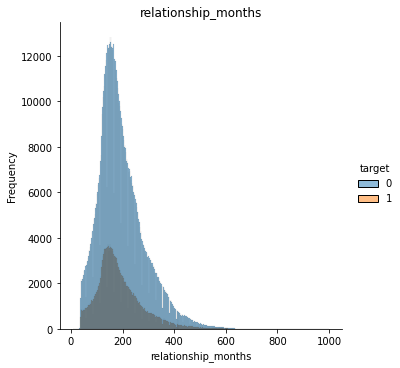

<module 'matplotlib.pyplot' from '/Users/aleksandram/.local/share/virtualenvs/PD-scoring-Yvrhi1rQ/lib/python3.9/site-packages/matplotlib/pyplot.py'>

In [ ]:
plot_histogram(dfv,'relationship_months', hue='target')
# customers with shorter relationship with the company are more likely to default 

In [ ]:
df.head()

,term,int_rate,installment,grade,sub_grade,home_ownership,annual_inc,issue_d,loan_status,dti,earliest_cr_line,recoveries,last_pymnt_d,application_type,target,grade_check
0,36 months,13.56,84.92,C,C1,RENT,"55,000.00",Dec-2018,Current,18.24,Apr-2001,0.00,Feb-2019,Individual,0,True
1,60 months,18.94,777.23,D,D2,MORTGAGE,"90,000.00",Dec-2018,Current,26.52,Jun-1987,0.00,Feb-2019,Individual,0,True
2,36 months,17.97,180.69,D,D1,MORTGAGE,"59,280.00",Dec-2018,Current,10.51,Apr-2011,0.00,Feb-2019,Individual,0,True
3,36 months,18.94,146.51,D,D2,MORTGAGE,"92,000.00",Dec-2018,Current,16.74,Feb-2006,0.00,Feb-2019,Individual,0,True
4,60 months,16.14,731.78,C,C4,MORTGAGE,"57,250.00",Dec-2018,Current,26.35,Dec-2000,0.00,Feb-2019,Individual,0,True


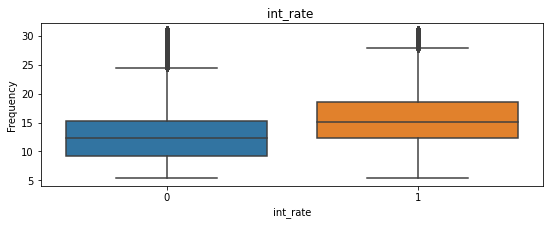

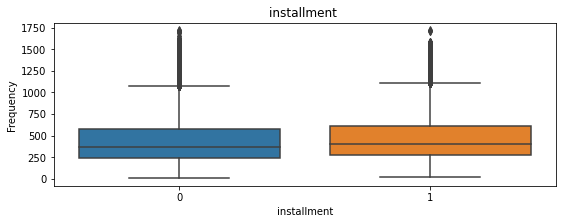

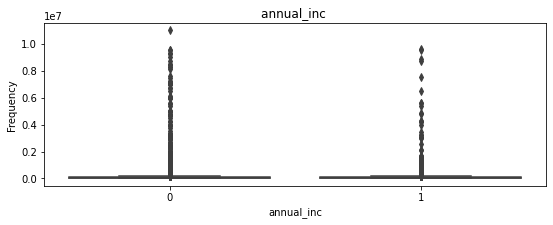

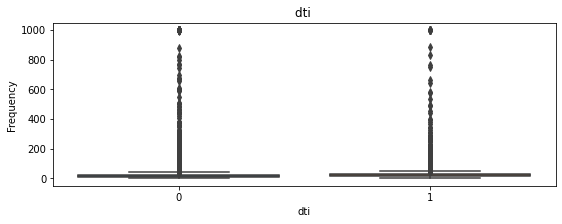

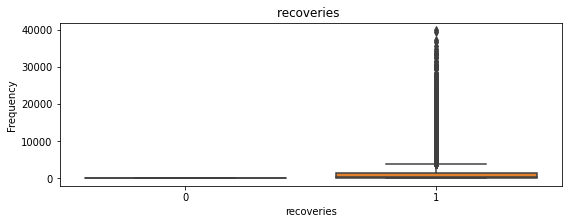

In [ ]:
for c in numerical:
    plot_box(dfv,c)

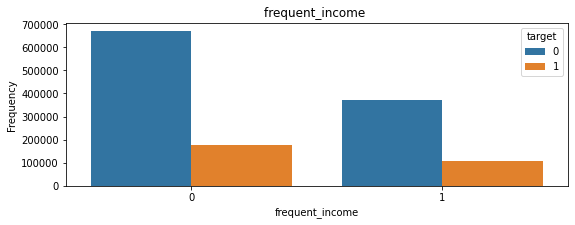

chi_2 statistic: 343.73
p_value: 0.00
significant level 0.05
Reject H0, variables have dependency


frequent_income
0   0.21
1   0.22
Name: target, dtype: float64

In [ ]:
plot_cnt(dfv,'frequent_income', hue='target')
chi_2(dfv, 'frequent_income')
dfv.groupby('frequent_income')['target'].mean()
#Looks like features are dependent but groups have the same default rates within the groups


<Figure size 648x216 with 0 Axes>

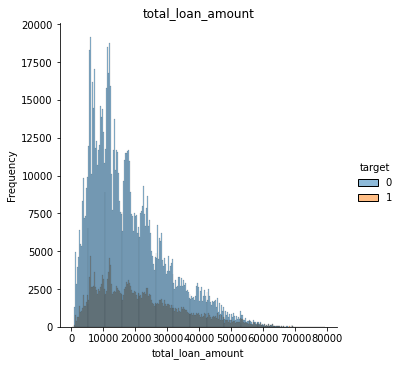

<module 'matplotlib.pyplot' from '/Users/aleksandram/.local/share/virtualenvs/PD-scoring-Yvrhi1rQ/lib/python3.9/site-packages/matplotlib/pyplot.py'>

In [ ]:
plot_histogram(df=dfv,variable= 'total_loan_amount', hue='target')

In [ ]:
dfv['lti'] = dfv['annual_installment'] / (dfv['annual_inc'])*10

In [ ]:
dfv[['annual_inc', 'annual_installment','lti']].head(30)

,annual_inc,annual_installment,lti
100,"100,000.00","13,813.92",1.38
152,"45,000.00","11,708.52",2.60
170,"100,000.00","7,472.16",0.75
186,"38,500.00","1,775.88",0.46
215,"450,000.00","4,142.16",0.09
269,"57,000.00","6,090.60",1.07
271,"45,000.00","2,604.60",0.58
296,"42,000.00","1,019.04",0.24
369,"60,000.00","1,734.60",0.29
379,"24,000.00","1,018.20",0.42


In [14]:
#plot_histogram(df=dfv ,variable= 'lti')

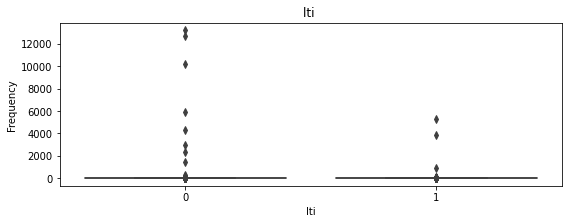

<module 'matplotlib.pyplot' from '/Users/aleksandram/.local/share/virtualenvs/PD-scoring-Yvrhi1rQ/lib/python3.9/site-packages/matplotlib/pyplot.py'>

In [ ]:
#plot_box(dfv, 'lti')

In [ ]:
# TODO mark "loan to income as checked feature"
# TODO calculate correlation between features

In [43]:
#VIP's are more likely to pay their debts
dfv['vip'] = np.where(dfv['annual_inc']>= 500000,1,0)

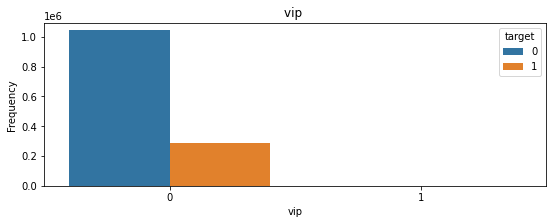

chi_2 statistic: 64.37
p_value: 0.00
significant level 0.05
Reject H0, variables have dependency


In [44]:
plot_cnt(dfv,'vip', hue='target')
chi_2(dfv, 'vip')

In [45]:
dfv.groupby('vip')['target'].mean()

vip
0   0.21
1   0.14
Name: target, dtype: float64